In [1]:
import h5py
import os
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
from HDF5 import HDF5
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

In [8]:
def read(parent):
    data = []
    counter = 0
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith('.hdf5') and counter<10:
                file_path = os.path.join(root, file)
                f = HDF5.HDF5()
                f.name = file_path
                data.append(f.load_hdf5()['Signals']['I'])
                counter = counter + 1
                print(f'reading file : {counter}')
    return data


In [9]:
data = read(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\10')

Execution time: 0.157
reading file : 1
Execution time: 0.159
reading file : 2
Execution time: 0.163
reading file : 3
Execution time: 0.159
reading file : 4
Execution time: 0.168
reading file : 5
Execution time: 0.161
reading file : 6
Execution time: 0.161
reading file : 7
Execution time: 0.159
reading file : 8
Execution time: 0.162
reading file : 9
Execution time: 0.167
reading file : 10


In [94]:
xmin, ymin = [np.argmin(data[5]) , max(-data[5])]

In [144]:
I = -data[5][xmin-3000:xmin+10000]
T = np.linspace(xmin-3000,xmin+10000,len(I),dtype=int)

In [145]:
# Apply moving average filter
window_size = 100  # Size of the moving average window
cumsum = np.cumsum(I)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [146]:
window_length = 71  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

In [180]:
p, pr = find_peaks(smoothed_signal,-7,distance=200)

In [185]:
for i,peak in enumerate(pr['peak_heights']):
    if i-1>0:
        if peak-pr['peak_heights'][i-1]>0.0005:
            print(T[i])

198209


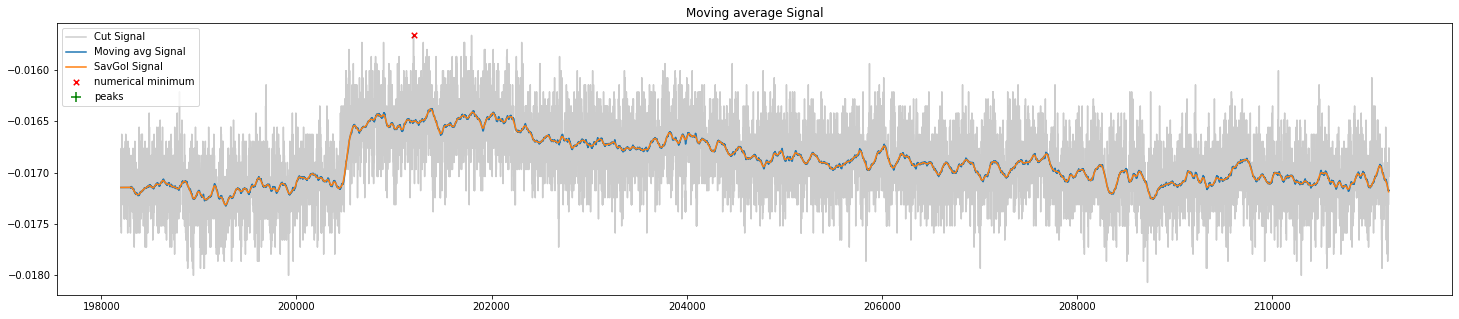

In [179]:
plt.figure(figsize=(25,5))
plt.plot(T, I, label='Cut Signal',color='black',alpha=0.2)
plt.plot(T, moving_avg, label='Moving avg Signal')
plt.plot(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal')
plt.scatter(xmin, ymin, marker='x',color='red',s=30,label='numerical minimum')
plt.scatter(T[p], pr['peak_heights'], marker='+',color='green',s=100,label='peaks')
plt.title('Moving average Signal')
plt.legend()

In [153]:
p, pr = find_peaks(smoothed_signal,-0.017,distance=200)
print(p)

[ 2395  2635  2943  3172  3602  3814  4146  4376  4578  4906  5250  5624
  5877  6129  6340  6767  7094  7353  7576  7825  8062  8292  8666  8959
  9217  9488 10043 10296 10949 11525 12905]


In [99]:
len_fit = int(np.floor(len(smoothed_signal)/10))
pol_amp = np.polyfit(T[:len_fit], I[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit])**2))   

In [100]:
def model(x, A,B,C,D):
    return A*np.exp(-B*(x-C))+D

def sigmoid(x, A, B, C, D):
    return A / (1.0 + np.exp(-B * (x - C))) + D

In [125]:
p0 = [14,0.00046,267200,np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit]))]
p0_sig = [0.0006,0.1,267200,np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit]))]

In [126]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [127]:
sig = LeastSquares(T[2000:3200],smoothed_signal[2000:3200],rms,sigmoid)
exp = LeastSquares(T[3200:len(smoothed_signal)],smoothed_signal[3200:len(smoothed_signal)],rms,model)
msig = Minuit(sig,*p0_sig)
mexp = Minuit(exp,*p0)
msig.migrad(iterate=1000)

C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D
C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1087 (χ²/ndof = 0.9)       │             Nfcn = 29046             │
│ EDM = 6.53e-14 (Goal: 0.0002)    │            time = 4.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   6e-4    │   0e-4    │            │            │         │         │       │
│ 1 │ B    │   1e-1    │   0e-1    │            │            │         │         │       │
│ 2 │ C    │  2.672e5  │  0.000e5  │            │            │         │         │       │
│ 3 │ D    │-1.6668e-2 │ 0.0000e-2 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [128]:
mexp.migrad(iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 646 (χ²/ndof = 0.1)        │              Nfcn = 890              │
│ EDM = 0.301 (Goal: 0.0002)       │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ 6.39e-15  │ 0.20e-15  │            │            │         │         │       │
│ 1 │ B    │  240e-6   │   5e-6    │            │            │         │         │       │
│ 2 │ C    │  307.3e3  │   2.0e3   │            │            │         │         │       │
│ 3 │ D    │-17.145e-3 │ 0.007e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│   │                         A                         B                         C                         D │
├───┼─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ A │                  4.01e-32         -984.53625089e-24 403.63786955380192012e-15         -957.56875995e-24 │
│ B │         -984.53625089e-24                  2.41e-11           -9.896108200e-3                  0.023e-9 │
│ C │ 403.63786955380192012e-15           -9.896108200e-3                  4.06e+06            -9.74926238e-3 │
│ D │         -957.56875995e-24                  0.023e-9            -9.74926238e-3                  4.63e-11 │
└───┴─────────────────────────────────────────────────────────────────────────────────────────────────────────┘

C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D
C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D


Text(0.5, 1.0, 'Time constant FIT')

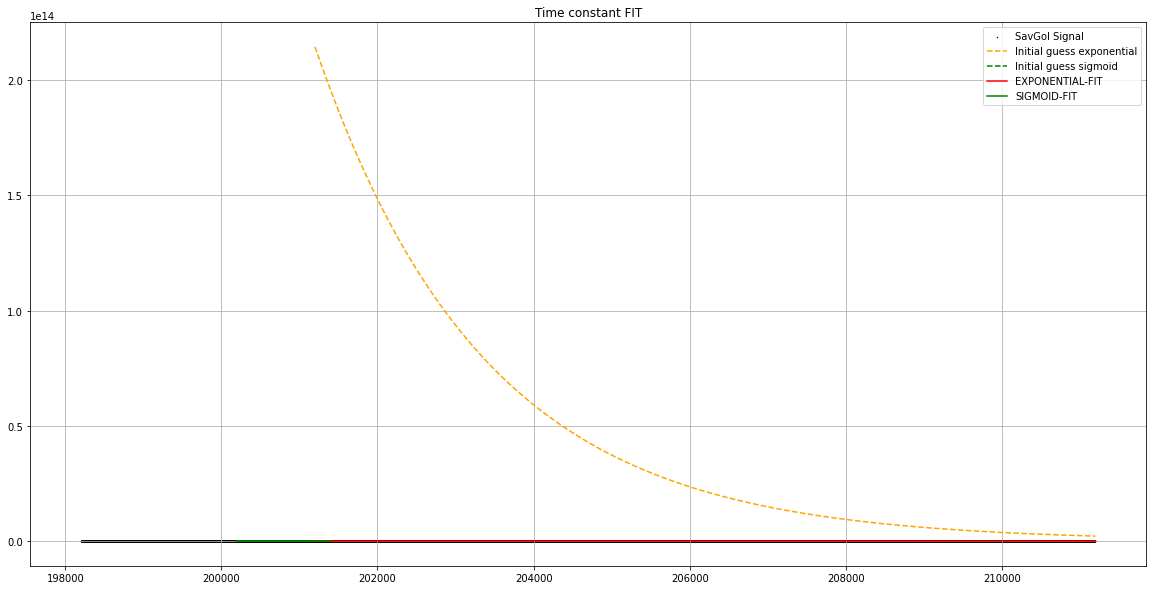

In [129]:
plt.figure(figsize=(20,10))
plt.scatter(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal',marker='.',s=1,color='black')
plt.plot(T[3000:13000],model(T[3000:13000],*p0),label='Initial guess exponential',linestyle='--',color='orange')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*p0_sig),label='Initial guess sigmoid',linestyle='--',color='green')
plt.plot(T[3000:13000],model(T[3000:13000],*mexp.values),label='EXPONENTIAL-FIT',linestyle='-',color='red')
plt.plot(T[2000:3200],sigmoid(T[2000:3200],*msig.values),label='SIGMOID-FIT',linestyle='-',color='green')
plt.legend()
plt.grid()
plt.title('Time constant FIT')

In [130]:
mexp.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,6.39e-15,0.20e-15,,,,,
1,B,240e-6,5e-6,,,,,
2,C,307.3e3,2.0e3,,,,,
3,D,-17.145e-3,0.007e-3,,,,,


In [131]:
msig.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,A,6e-4,0e-4,,,,,
1,B,1e-1,0e-1,,,,,
2,C,2.672e5,0.000e5,,,,,
3,D,-1.6668e-2,0.0000e-2,,,,,


In [132]:
# Calculate the 10% and 90% points of the fitted signal
y_10 = msig.values['D'] + 0.1 * msig.values['A']
y_90 = msig.values['D'] + 0.9 * msig.values['A']

# Find the time at which the signal reaches these values
t_10 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_10).argmin()]
t_90 = T[np.abs(sigmoid(T[2000:3200],*msig.values) - y_90).argmin()]

# Calculate the rise time
rise_time = (t_90 - t_10)*1e-8
print(f"Rise Time: {rise_time*1e6:.4f} micro seconds")

Rise Time: 0.0000 micro seconds


C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D


In [133]:
fitted_signal = np.array(list(sigmoid(T[0:3000],*msig.values))+list(model(T[3000:],*mexp.values)))

C:\Users\kid\AppData\Local\Temp\ipykernel_9588\1250387595.py:5: RuntimeWarning: overflow encountered in exp
  return A / (1.0 + np.exp(-B * (x - C))) + D


In [134]:
window = 111 
polyorder = 3 
fd = savgol_filter(fitted_signal,window, polyorder, deriv=1) 
sd = savgol_filter(fitted_signal,window, polyorder, deriv=2) 

In [135]:
th = 4*1e-8
peaks, props = find_peaks(sd, th)
peak = peaks[np.argmax(props['peak_heights'])]

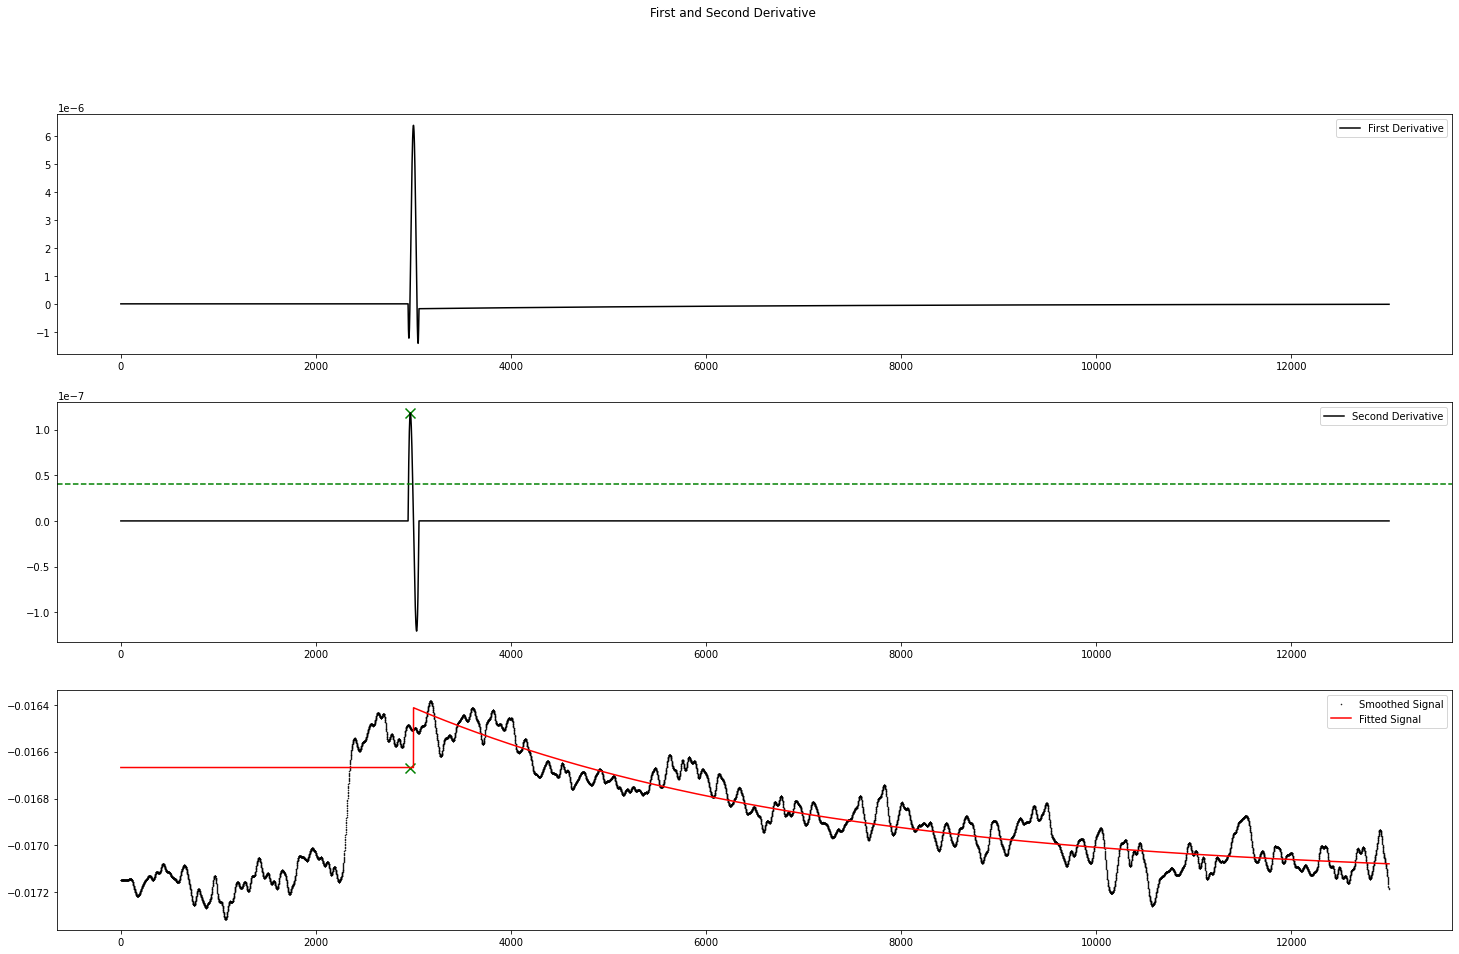

In [136]:
fig, axs = plt.subplots(3,1,figsize=(25,15))
axs[1].plot(np.linspace(0,len(sd),len(sd)),sd,color='black',label='Second Derivative')
axs[0].plot(np.linspace(0,len(fd),len(fd)),fd,color='black',label='First Derivative')
#axs[0].axhline(th, 0, 1, linestyle='--', color='green')
axs[2].scatter(np.linspace(0,len(smoothed_signal),len(smoothed_signal)), smoothed_signal, label='Smoothed Signal',marker='.',color='black',s=1)
axs[2].plot(np.linspace(0,len(fitted_signal),len(fitted_signal)), fitted_signal, label='Fitted Signal',color='red')
axs[1].scatter(peak, max(props['peak_heights']), marker='x', color='green', s=100)
axs[2].scatter(peak, fitted_signal[peak], marker='x', color='green', s=100)
axs[1].axhline(th, 0, 1, linestyle='--', color='green')
fig.suptitle('First and Second Derivative')
axs[0].legend()
axs[1].legend()
axs[2].legend()

In [248]:
with open('Trigger.txt','a') as file:
    file.writelines('\n'+str(peaks[0])+'\t'+str(props['peak_heights'][0]))